# Playground
Let's get back in the game with pytorch and autoencoders. Given some toy dataset (mixture of Gaussians and MNIST), let's get some autoencoders encoding!

In [1]:
import sys

import numpy as np

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
from torch import optim

from sklearn.datasets import fetch_mldata

from tqdm import tqdm
import time

from utils import progress, count_parameters, visualize, get_batch

import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

In [2]:
cuda = torch.cuda.is_available() # True if cuda is available, False otherwise
FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor
print('Training on %s' % ('GPU' if cuda else 'CPU'))

Training on GPU


## Toy data

Mixture of Gausians.

In [6]:
N1 = 10000
N2 = 3000
N = N1 + N2
X1 = np.random.multivariate_normal([3, 3], [[1, -.9], [-.9, 1]], size=N1)
X1 = torch.from_numpy(X1).type(torch.FloatTensor)
X2 = np.random.multivariate_normal([-5, -5], [[1.5, .7], [.7, 1.5]], size=N2)
X2 = torch.from_numpy(X2).type(torch.FloatTensor)
X = torch.cat([X1, X2])

S = .8
N_train = int(N * S)
split = torch.randperm(X.size(0))
X_train = X[split[:N_train]]
X_test = X[split[N_train:]]

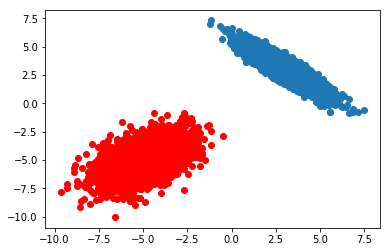

In [7]:
plt.scatter(*zip(*X1.numpy()))
plt.scatter(*zip(*X2.numpy()), c='r')
plt.show()

In [3]:
# def get_batch(data, batch_size, allow_smaller_batch=False):
#     N = data.shape[0]
#     indexes = torch.randperm(N)
#     for i in range(0, N, batch_size):
#         if not allow_smaller_batch and i + batch_size > N - 1:
#             break
#         yield data[indexes[i: i + batch_size]]

## Basic autoencoder

### Mixture of Gaussian

In [14]:
def autoencoder(p, b):
    encoder = nn.Sequential(
            nn.Linear(p, 32),
            nn.ReLU(),
            nn.Linear(32, b))
    decoder = nn.Sequential(
            nn.ReLU(),
            nn.Linear(b, 32),
            nn.ReLU(),
            nn.Linear(32, p))
    ae = nn.Sequential(encoder, decoder)
    return encoder, decoder, ae

encoder, decoder, net1 = autoencoder(p=2, b=2)
net1 = net1.type(FloatTensor)

In [15]:
optimizer = torch.optim.RMSprop(params=net1.parameters(), lr=0.01)
criterion = lambda x,y: ((x - y) ** 2).sum(1).mean()

In [18]:
batch_size = 32
max_epochs = 20
for i in range(max_epochs):
    loss_agg = []
    for x in get_batch(X_train, batch_size):
        net1.train()
        x = Variable(x).type(FloatTensor)
        x_ = net1(x)
        net1.zero_grad()
        loss = criterion(x, x_)
        loss.backward()
        optimizer.step()
        loss_agg.append(loss.data.cpu().numpy())
    print('[%i/%i] loss %.4f' % (i+1, max_epochs, np.mean(loss_agg)))

[1/20] loss 2.0590
[2/20] loss 0.4425
[3/20] loss 0.3640
[4/20] loss 0.2186
[5/20] loss 0.2005
[6/20] loss 0.1901
[7/20] loss 0.1683
[8/20] loss 0.1563
[9/20] loss 0.1513
[10/20] loss 0.1577
[11/20] loss 0.1520
[12/20] loss 0.1373
[13/20] loss 0.1195
[14/20] loss 0.0952
[15/20] loss 0.0828
[16/20] loss 0.0723
[17/20] loss 0.0700
[18/20] loss 0.0669
[19/20] loss 0.0679
[20/20] loss 0.0557


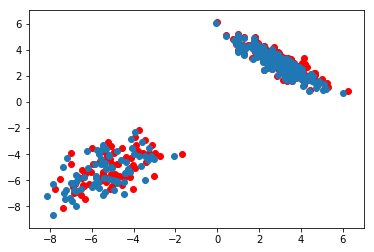

In [25]:
net1.eval()
idx = torch.randperm(X_test.size(0))[:300]
X_test_ = X_test[idx].type(FloatTensor)
x_ = net1(Variable(X_test_))
x_ = x_.type(FloatTensor)
loss = criterion(x_, Variable(X_test_))

plt.scatter(*zip(*X_test_.cpu().numpy()), c='r')
plt.scatter(*zip(*x_.data.cpu().numpy()))

Let's plot the latent space.

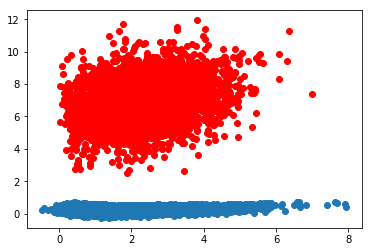

In [29]:
code1, code2 = encoder(Variable(X1.type(FloatTensor))), encoder(Variable(X2.type(FloatTensor)))
plt.scatter(*zip(*code1.data.cpu().numpy()[:, :2]))
plt.scatter(*zip(*code2.data.cpu().numpy()[:, :2]), c='r');
# plt.hist(code1.data.numpy())
# plt.hist(code2.data.numpy());

### MNIST

In [3]:
mnist = fetch_mldata('MNIST original', data_home='.')

In [4]:
mnist.data = mnist.data.astype(np.float32) / 255
#mnist.data = (mnist.data - 0.1307) / 0.3081

In [6]:
z = 128
net2 = nn.Sequential(
                # Encoder
                nn.Linear(28 * 28, 512),
                nn.PReLU(512),
                nn.BatchNorm1d(512),
                nn.Linear(512, 128),
                nn.PReLU(128),
    
                # Low-dimensional representation
                nn.Linear(128, z),   
                nn.PReLU(z),
                nn.BatchNorm1d(z),
    
                # Decoder
                nn.Linear(z, 128),
                nn.PReLU(128),
                nn.BatchNorm1d(128),
                nn.Linear(128, 512),
                nn.PReLU(512),
                nn.Linear(512, 28 * 28),
                nn.Sigmoid()).type(FloatTensor)
count_parameters(net2)
optimizer = torch.optim.Adam(params=net2.parameters(), lr=0.01)

971,792 parameters
971,792 trainable parameters


In [7]:
max_epochs = 20
batch_size = 300
N = mnist.data.shape[0]
for i in range(max_epochs):
    loss_agg = []
    start = time.time()
    for j, x in enumerate(get_batch(mnist.data, batch_size, allow_smaller_batch=True)):
        x = Variable(torch.from_numpy(x).type(FloatTensor))
        x = x.view(x.size(0), -1)
        net2.zero_grad()
        x_ = net2(x)
        loss = torch.dist(x, x_) 
        #loss = torch.nn.BCELoss()(x_, x) * batch_size
        loss.backward()
        optimizer.step()
        loss_agg.append(loss.data.cpu().numpy())
        progress(loss_agg, i + 1, max_epochs, j + 1, batch_size, N, start, net2, mnist.data[:55000], in_size=[28*28])

[ 1/20][==================================================] 100% – loss 72.27397 -    1s [58737 fps]
[ 2/20][==================================================] 100% – loss 52.04363 -    1s [60056 fps]
[ 3/20][==================================================] 100% – loss 46.62912 -    1s [59727 fps]
[ 4/20][==================================================] 100% – loss 43.96217 -    1s [61114 fps]
[ 5/20][==================================================] 100% – loss 41.92686 -    1s [60185 fps]
[ 6/20][==================================================] 100% – loss 40.36091 -    1s [61103 fps]
[ 7/20][==================================================] 100% – loss 39.50294 -    1s [46396 fps]
[ 8/20][==================================================] 100% – loss 38.59072 -    1s [52654 fps]
[ 9/20][==================================================] 100% – loss 37.97836 -    1s [57509 fps]
[10/20][==================================================] 100% – loss 37.60262 -    1s [5

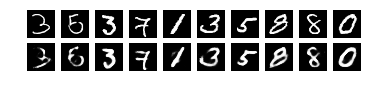

In [8]:
visualize(net2, mnist.data[:55000], in_size=[28*28], dtype=FloatTensor)

In [9]:
z = 8 # default=8
net3  = nn.Sequential(
                # Encoder
                nn.Conv2d(1, 32, 3, padding=1), # input (1, 28, 28), output (32, 28, 28)
                nn.PReLU(32),
                nn.BatchNorm2d(32),
                nn.MaxPool2d(2), # (32, 14, 14)
                nn.Conv2d(32, 64, 3), # (64, 12, 12)
                nn.PReLU(64),
                nn.BatchNorm2d(64),
                nn.MaxPool2d(2), # (64, 6, 6))
                
                # Low-dimensional representation
                nn.Conv2d(64, z, 3), # (8, 4, 4) -- latent representation
                nn.PReLU(z),
                nn.BatchNorm2d(z),
                
                # Decoder
                nn.Conv2d(z, 64, 3, padding=2), # (64, 6, 6)
                nn.Upsample(scale_factor=2), # (64, 12, 12)
                nn.Conv2d(64, 32, 3, padding=2), # (32, 14, 14)
                nn.PReLU(32),
                nn.Upsample(scale_factor=2), # (32, 28, 28)
                nn.Conv2d(32, 1, 3, padding=1),
                nn.Sigmoid()).type(FloatTensor).type(FloatTensor)
count_parameters(net3)
optimizer = torch.optim.Adam(params=net3.parameters(), lr=0.01)

47,201 parameters
47,201 trainable parameters


In [10]:
N = mnist.data.shape[0]
batch_size = 300
max_epochs = 20
for i in range(max_epochs):
    loss_agg = []
    start = time.time()
    for j, x in enumerate(get_batch(mnist.data, batch_size, allow_smaller_batch=True)):
        x = Variable(torch.from_numpy(x).type(FloatTensor).view(-1, 1, 28, 28))
        x_ = net3(x)
        net3.zero_grad()
        loss = torch.dist(x, x_)
        #loss = nn.BCELoss()(x_, x)
        loss.backward()
        optimizer.step()
        loss_agg.append(loss.data.cpu().numpy())
        progress(loss_agg, i + 1, max_epochs, j + 1, batch_size, N, start)

[ 1/20][==================================================] 100% – loss 48.08679 -    4s [14781 fps]
[ 2/20][==================================================] 100% – loss 29.88964 -    4s [14928 fps]
[ 3/20][==================================================] 100% – loss 27.74132 -    4s [14925 fps]
[ 4/20][==================================================] 100% – loss 26.58418 -    4s [14895 fps]
[ 5/20][==================================================] 100% – loss 25.71063 -    4s [14892 fps]
[ 6/20][==================================================] 100% – loss 25.36725 -    4s [14882 fps]
[ 7/20][==================================================] 100% – loss 25.17484 -    4s [14899 fps]
[ 8/20][==================================================] 100% – loss 24.78431 -    4s [14927 fps]
[ 9/20][==================================================] 100% – loss 24.45155 -    4s [14909 fps]
[10/20][==================================================] 100% – loss 24.53586 -    4s [1

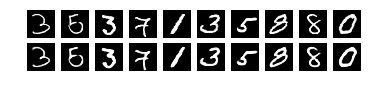

In [12]:
visualize(net3, mnist.data[:55000], in_size=[1, 28, 28], dtype=FloatTensor)

In [13]:
class Autoencoder(nn.Module):
    def __init__(self, zdim=8):
        super(Autoencoder, self).__init__()
        self.iterations = 0
        self.encoder = nn.Sequential(
                nn.Conv2d(1, 32, 3, padding=1, stride=2, bias=False),
                nn.PReLU(32),
                nn.BatchNorm2d(32),
                nn.Conv2d(32, 64, 3, padding=1, stride=2, bias=False),
                nn.PReLU(64),
                nn.BatchNorm2d(64),
                nn.Conv2d(64, zdim, 4, padding=0, stride=2, bias=False), 
                )
        self.decoder = nn.Sequential(
                nn.PReLU(zdim),
                nn.BatchNorm2d(zdim),
                nn.ConvTranspose2d(zdim, 64, 4, stride=2, padding=0, output_padding=1, bias=False),
                nn.PReLU(64),
                nn.BatchNorm2d(64),
                nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1, bias=False),
                nn.PReLU(32),
                nn.BatchNorm2d(32),
                nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1),
                nn.Sigmoid())

    def encode(self, x):
        #print(x.size()) if not self.iterations else _
        for l in self.encoder:
            x = l(x)
            #print(x.size(), l) if not self.iterations else _
        return x
    
    def decode(self, x):
        #print(x.size()) if not self.iterations else _
        for l in self.decoder:
            x = l(x)
            #print(x.size(), l) if not self.iterations else _
        return x
    
    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        self.iterations += 1
        return x

zdim = 8
net4 = Autoencoder(zdim).type(FloatTensor)
#net4 = torch.nn.DataParallel(net4, device_ids=[0, 1]) if cuda else net4
count_parameters(net4)
optimizer = torch.optim.Adam(params=net4.parameters(), lr=0.01)

54,425 parameters
54,425 trainable parameters


In [14]:
max_epochs = 20
for i in range(max_epochs):
    loss_agg = []
    start = time.time()
    for j, x in enumerate(get_batch(mnist.data, batch_size, allow_smaller_batch=True)):
        x = Variable(torch.from_numpy(x).type(FloatTensor).view(-1, 1, 28, 28))
        x_ = net4(x)
        net4.zero_grad()
        loss = torch.dist(x, x_)
        #loss = nn.BCELoss()(x_, x)
        loss.backward()
        optimizer.step()
        loss_agg.append(loss.data.cpu().numpy())
        progress(loss_agg, i + 1, max_epochs, j + 1, batch_size, N, start)
    else:
        optimizer.param_groups[0]['lr'] *= .95

[ 1/20][==================================================] 100% – loss 65.35703 -   16s [4166 fps]
[ 2/20][==================================================] 100% – loss 47.52147 -   16s [4168 fps]
[ 3/20][==================================================] 100% – loss 45.84605 -   16s [4173 fps]
[ 4/20][==================================================] 100% – loss 44.69401 -   16s [4169 fps]
[ 5/20][==================================================] 100% – loss 44.11574 -   16s [4188 fps]
[ 6/20][==================================================] 100% – loss 43.73838 -   16s [4175 fps]
[ 7/20][==================================================] 100% – loss 43.31929 -   16s [4180 fps]
[ 8/20][==================================================] 100% – loss 43.06805 -   16s [4175 fps]
[ 9/20][==================================================] 100% – loss 42.93793 -   16s [4192 fps]
[10/20][==================================================] 100% – loss 42.74572 -   16s [4170 fps]


code size = torch.Size([8, 2, 2])


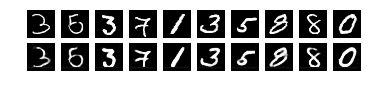

In [15]:
visualize(net4, mnist.data[:55000], in_size=[1, 28, 28], dtype=FloatTensor)

## Adversarial autoencoder

In [92]:
class Encoder(nn.Module):
    def __init__(self, z_dim):
        super(Encoder, self).__init__()
        self.iterations = 0
        self.encoder_top = nn.Sequential(
                            nn.Conv2d(1, 64, 3, padding=1, stride=2),
                            nn.PReLU(64),
                            nn.BatchNorm2d(64),
                            nn.Conv2d(64, 64, 3, padding=1, stride=2), # (64, 12, 12)
                            nn.PReLU(64),
                            nn.BatchNorm2d(64),
                            nn.Conv2d(64, 8, 3, padding=1, stride=2), # (8, 4, 4)
                            nn.ReLU(),
                            nn.BatchNorm2d(8))
        self.encoder_bottom = nn.Sequential(
                            nn.Linear(8 * 4 * 4, 128),
                            nn.ReLU(),
                            nn.Linear(128, z_dim))

    def forward(self, x):
        #print(x.size()) if not self.iterations else _
        for l in self.encoder_top:
            x = l(x)
            #print(x.size(), l) if not self.iterations else _
            
        x = x.view(x.size(0), -1)
        #print(x.size()) if not self.iterations else _
        
        for l in self.encoder_bottom:
            x = l(x)
            #print(x.size(), l) if not self.iterations else _
        self.iterations += 1
        return x


class Decoder(nn.Module):
    def __init__(self, z_dim):
        super(Decoder, self).__init__()
        self.iterations = 0
        self.decoder_top = nn.Sequential(
                            nn.Linear(z_dim, 128),
                            nn.ReLU(),
                            nn.BatchNorm1d(128),
                            nn.Linear(128, 8 * 4 * 4),
                            nn.ReLU(),
                            nn.BatchNorm1d(8 * 4 * 4))
#         self.decoder_bottom = nn.Sequential(
#                             nn.ConvTranspose2d(8, 64, 3, stride=2, padding=1),
#                             nn.PReLU(64),
#                             nn.BatchNorm2d(64),
#                             nn.ConvTranspose2d(64, 64, 3, stride=2, padding=1, output_padding=1),
#                             nn.PReLU(64),
#                             nn.ConvTranspose2d(64, 1, 3, stride=2, padding=1, output_padding=1),
#                             nn.Sigmoid()) # (1, 28, 28)
        self.decoder_bottom = nn.Sequential(
                            nn.Conv2d(z, 64, 3, padding=2), # (64, 6, 6)
                            nn.Upsample(scale_factor=2), # (64, 12, 12)
                            nn.Conv2d(64, 32, 3, padding=2), # (32, 14, 14)
                            nn.PReLU(32),
                            nn.Upsample(scale_factor=2), # (32, 28, 28)
                            nn.Conv2d(32, 1, 3, padding=1),
                            nn.Sigmoid())

        
    def forward(self, x):
        #print(x.size()) if not self.iterations else _
        for l in self.decoder_top:
            x = l(x)
            #print(x.size(), l) if not self.iterations else _
            
        x = x.view(x.size(0), 8, 4, 4)
        #print(x.size()) if not self.iterations else _
        
        for l in self.decoder_bottom:
            x = l(x)
            #print(x.size(), l) if not self.iterations else _
        self.iterations += 1
        return x
  
    
z_dim = 8
discriminator5 = nn.Sequential(
            nn.Linear(z_dim, 128),
            nn.PReLU(128),
            nn.BatchNorm1d(128),
            nn.Linear(128, 32),
            nn.PReLU(32),
            nn.Linear(32, 1),
            nn.Sigmoid()).type(FloatTensor)

encoder5 = Encoder(z_dim).type(FloatTensor)
decoder5 = Decoder(z_dim).type(FloatTensor)
net5 = nn.Sequential(encoder5, decoder5).type(FloatTensor)

In [93]:
lr = 0.01 # learning rate
criterion = nn.BCELoss()
optimizer_ae = torch.optim.Adam(params=net5.parameters(), lr=lr)
optimizer_d = torch.optim.Adam(params=discriminator5.parameters(), lr=0.001)
optimizer_g = torch.optim.Adam(params=encoder5.parameters(), lr=lr)

In [97]:
info = {}
info['recon_loss'] = []
info['discriminator_loss'] = []
info['generator_loss'] = []

max_epochs = 10
for i in range(max_epochs):
    start = time.time()
    for j, x in enumerate(get_batch(mnist.data, batch_size, allow_smaller_batch=True)):
        batch = x.shape[0]
        ones = Variable(torch.ones(batch)).type(FloatTensor)
        zeros = Variable(torch.zeros(batch)).type(FloatTensor)
        
        # (1) Reconstruction loss
        encoder5.zero_grad()
        decoder5.zero_grad()
        discriminator5.zero_grad()
        x = Variable(torch.from_numpy(x).type(FloatTensor).view(-1, 1, 28, 28))
        x_ = net5(x)
        reconstruction_loss = torch.dist(x, x_)
        reconstruction_loss.backward()
        optimizer_ae.step()
        
        # (2) Train the discriminator
        discriminator5.zero_grad()
        z_fake = encoder5(x.detach())
        z_real = Variable(torch.randn(z_fake.size())).type(FloatTensor)
        z_fake_d = discriminator5(z_fake)
        z_real_d = discriminator5(z_real)

        loss_real = criterion(z_real_d.squeeze(), ones)
        loss_fake = criterion(z_fake_d.squeeze(), zeros)
        loss_d = loss_real + loss_fake
        loss_d.backward()
        optimizer_d.step()

        # (3) Generator step
    
        encoder5.zero_grad()
        z_fake = encoder5(x)
        z_fake_d = discriminator5(z_fake)
        loss_g = criterion(z_fake_d.squeeze(), ones)
        loss_g.backward()
        optimizer_g.step()
    
        
        info['recon_loss'].append(reconstruction_loss.data.item())
        info['discriminator_loss'].append(loss_d.data.item())
        info['generator_loss'].append(loss_g.data.item())
        
        progress(info['recon_loss'], i + 1, max_epochs, j + 1, batch_size, N, start)
    print('[%2i/%2i] recon_loss %.3f D_loss %.3f G_loss %.3f' %
      (i + 1, max_epochs, np.mean(info['recon_loss']),
       np.mean(info['discriminator_loss']), np.mean(info['generator_loss'])))

    info['recon_loss'] = []
    info['discriminator_loss'] = []
    info['generator_loss'] = []

[ 1/10][==================================================] 100% – loss 85.31589 -    7s [9407 fps]
[ 1/10] recon_loss 85.316 D_loss 0.044 G_loss 7.215
[ 2/10][==================================================] 100% – loss 81.48152 -    7s [9343 fps]
[ 2/10] recon_loss 81.482 D_loss 0.006 G_loss 7.530
[ 3/10][==================================================] 100% – loss 80.25755 -    7s [9333 fps]
[ 3/10] recon_loss 80.258 D_loss 0.001 G_loss 7.987
[ 4/10][==================================================] 100% – loss 83.61201 -    7s [9415 fps]
[ 4/10] recon_loss 83.612 D_loss 0.003 G_loss 8.071
[ 5/10][==================================================] 100% – loss 85.58697 -    7s [9555 fps]
[ 5/10] recon_loss 85.587 D_loss 0.005 G_loss 7.480
[ 6/10][==================================================] 100% – loss 79.93953 -    7s [9364 fps]
[ 6/10] recon_loss 79.940 D_loss 0.001 G_loss 8.435
[ 7/10][==================================================] 100% – loss 80.69614 -    7s

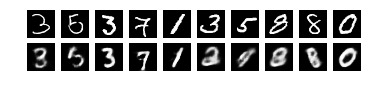

In [96]:
visualize(net5, mnist.data[:55000], in_size=[1, 28, 28], dtype=FloatTensor)

In [76]:
n = 10000
idx = np.random.choice(range(70000), size=n, replace=False)
images, labels = mnist.data[idx], mnist.target[idx]
images = Variable(torch.from_numpy(images)).type(FloatTensor)
images = images.view((-1, 1, 28, 28))
code = encoder5(images)

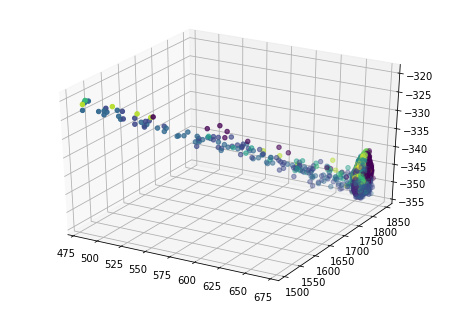

In [77]:
import pylab
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

fig = pylab.figure()
ax = Axes3D(fig)

ax.scatter(*zip(*code.data.cpu().numpy()[:, :3]), c=labels);